In [1]:
import pandas as pd
from CTL2.causal_tree_learn import CausalTree
from DGP.dgp2 import dgp2
from DGP.dgp1 import dgp1
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from CTL.causal_tree_learn import CausalTree as CT2
from random import random

In [2]:
#!pip install causal_tree_learn

#### Data Generation Process:

$$
y_i = -D + 2*D*1(x>0) + x_2 + e_i
$$

#### Average treatment effect:
$$
\tau(D) = E(y|D=1, X) - E(y|D=0, X) = 0
$$
#### ATE given x>0:
$$
\tau_1 (D, x_1) =  E(y|D=1, x_1 >0, X) - E(y|D=0, x_1 > 0, X)
$$
$$
\tau_1 (D, x_1) = -1 + 2 - 0
$$
$$
\tau_1 = 1
$$
#### ATE given x<0:
$$
\tau_2 (D, x_1) =  E(y|D=1, x_1 <0, X) - E(y|D=0, x_1 < 0, X)
$$
$$
\tau_2 (D, x_1) = -1 + 0 - 0
$$

$$
\tau_2 = -1
$$


#### Testing treatment effect MC:

n = 1000, reps = 100

In [17]:
n=1000
ate = []
ate1 = []
ate0 = []

for i in range(100):
    X, y = dgp2(n)
    data = pd.DataFrame({'y': y[:,0], 'X1': X[:,0], 'd': X[:,4]}, columns=['y', 'X1', 'd'])
    ate1.append(data['y'][(data['X1'] > 0) & (data['d'] == 1)].mean() - data['y'][(data['X1'] > 0) & (data['d'] == 0)].mean())
    ate0.append(data['y'][(data['X1'] < 0) & (data['d'] == 1)].mean() - data['y'][(data['X1'] < 0) & (data['d'] == 0)].mean())
    ate.append(data['y'][data['d'] == 1].mean() - data['y'][data['d'] == 0].mean())

print('_______________')
print('ATE when x>0')
print(np.mean(ate1))
print('_______________')
print('ATE when x<0')
print(np.mean(ate0))
print('_______________')
print('ATE')
print(np.mean(ate))

_______________
ATE when x>0
1.0014720383545588
_______________
ATE when x<0
-1.0102644713687627
_______________
ATE
0.0028919157820613325


In [2]:
def MC_trial(n, reps, nomin_test):
    ate1_true = []
    ate1_test = []
    ate1_control = []
    ate0_true = []
    ate0_test = []
    ate0_control = []
    
    for i in range(reps):
        np.random.seed()
        #generate new data following dgp2
        X, y = dgp2(n) 
        x = X[:,0:4]
        treatment = X[:,4]
        y = y[:,0]
        #print(np.mean(y))
        
        
        x_train, x_test, y_train, y_test, treat_train, treat_test = train_test_split(x, y, treatment, test_size=0.5)
        #print(np.mean(y_train))
        
        
        # honest CT (Athey and Imbens, PNAS 2016)
        ctl = CausalTree(honest=True, weight=0.0, split_size=0.0) #which type of tree to call
        
        #select est size when fitting
        ctl.fit(x_train, y_train, treat_train, nomin_test = nomin_test)
        ctl.prune()
        ctl_predict = ctl.predict(x_test)
        
         #for control, unmodified CT imported from a published package
        cthl = CT2(honest = True, weight=0.0, split_size=0.0)
        cthl.fit(x_train, y_train, treat_train)
        cthl.prune()
        cthl_predict = cthl.predict(x_test)

        
        #data = pd.DataFrame({'y': y_test, 'X1': x_test[:,0], 'X2': x_test[:,1], 'X3': x_test[:,2], 'X4': x_test[:,3], 'd':treat_test, 'tr1': ctl_predict, 'tr2': cthl_predict})
        x1 = x_test[:,0]
        ate1_true.append(np.mean(y_test[np.where((x1 > 0) & (treat_test == 1))]) - np.mean(y_test[np.where((x1 > 0) & (treat_test == 0))]))
        ate1_test.append(np.mean(ctl_predict[np.where(x1 > 0)]))
        ate1_control.append(np.mean(cthl_predict[np.where(x1 > 0)]))
        ate0_true.append(np.mean(y_test[np.where((x1 < 0) & (treat_test == 1))]) - np.mean(y_test[np.where((x1 < 0) & (treat_test == 0))]))
        ate0_test.append(np.mean(ctl_predict[np.where(x1 < 0)]))
        ate0_control.append(np.mean(cthl_predict[np.where(x1 < 0)]))

    #print('Test sample size: ' + str(nomin_test))
    #print(np.mean(ate1_true))
    #print(np.mean(ate1_test))
    #print(np.mean(ate1_control))
    #print(np.mean(ate0_true))
    #print(np.mean(ate0_test))
    #print(np.mean(ate0_control))
    
    #outputs
    return ate1_true, ate1_test, ate1_control, ate0_true, ate0_test, ate0_control

Check if test with 0.5 equals control

In [91]:
reps = 100
n = 500
nomin_test = 0.5

ATE1 = []
ATE1_t = []
ATE1_c = []
ATE0 = []
ATE0_t = []
ATE0_c = []

results = MC_trial(n,reps,nomin_test)

In [92]:
for i in results:
    print(np.mean(i))

0.9345892563897928
0.6818908757658585
0.6818908771289551
-1.0276629145453517
-0.7156169475093641
-0.7156169435692974


reps = 100, n = 1000

In [67]:
reps = 100
n = 1000

test_sizes = [0.1, 0.25, 0.5, 0.75, 0.8]

ATE1 = []
ATE1_t = []
ATE1_c = []
ATE0 = []
ATE0_t = []
ATE0_c = []

ATES = [[],[],[],[],[],[]]


#results = MC_trial(n,reps,nomin_test)

for size in test_sizes:
    nomin_test = size
    results = MC_trial(n, reps, nomin_test)
    k = 0
    for i in ATES:
        i.append(np.mean(results[k]))
        k = k + 1

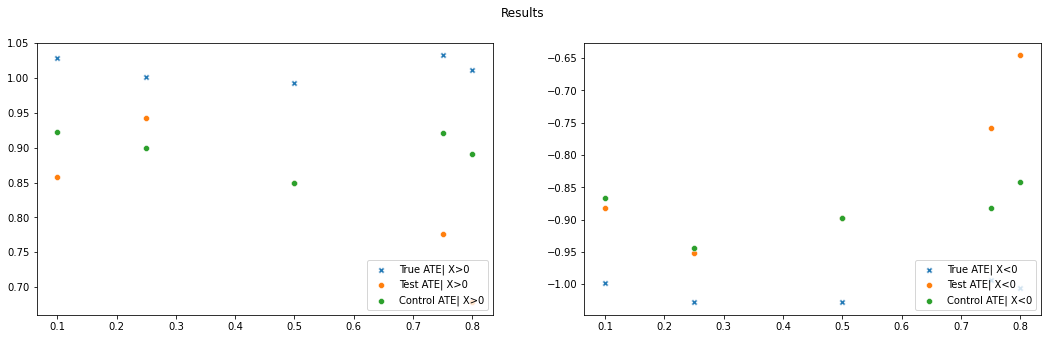

In [76]:
import seaborn as sns

fig, axes = plt.subplots(1,2, figsize=(18, 5))
fig.suptitle('Results')

sns.scatterplot(ax=axes[0], x=test_sizes, y=ATES[0], marker="X")
sns.scatterplot(ax=axes[1], x=test_sizes, y=ATES[3], marker="X")

for i in range(0,2):
    sns.scatterplot(ax=axes[0], x=test_sizes, y=ATES[i+1])
    sns.scatterplot(ax=axes[1], x=test_sizes, y=ATES[i+4])
    
axes[0].legend(['True ATE| X>0', 'Test ATE| X>0', 'Control ATE| X>0'], loc='lower right')
axes[1].legend(['True ATE| X<0', 'Test ATE| X<0', 'Control ATE| X<0'], loc='lower right')

In [19]:
#MSE
#bias = (est ate - 1)/R +
#var = variance of ATE/R 

#how many times the algorithm finds the incorrect split or splits more than once

#total MSE

# add x5 -> irrelevant
# increase variance of epsilon


#conditional graphs with MSE's on vertical axis
# variance
# bias separately
    #all the above for x>0, x<0 ==> 6 pictures

#Total MSE
    #as function of split proportion
    #break to bias a variance maybe

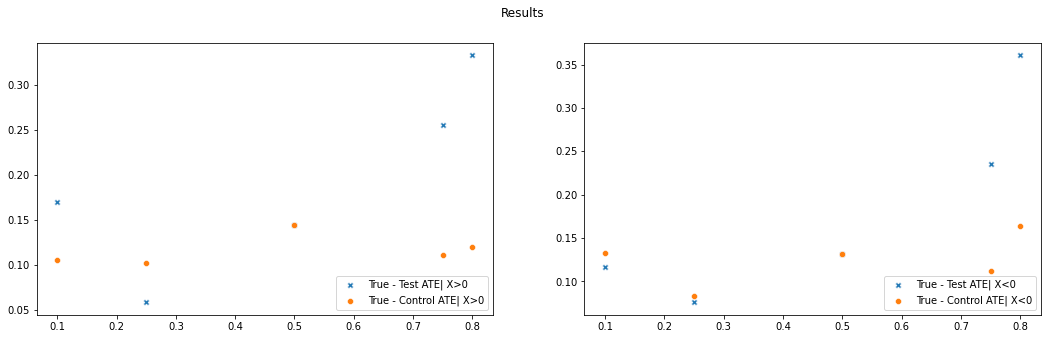

In [86]:
fig, axes = plt.subplots(1,2, figsize=(18, 5))
fig.suptitle('Results')

Y1 = abs(np.array(ATES[0]) - np.array(ATES[1]))
Y1c = abs(np.array(ATES[0]) - np.array(ATES[2]))
Y2 = abs(np.array(ATES[3]) - np.array(ATES[4]))
Y2c = abs(np.array(ATES[3]) - np.array(ATES[5]))

sns.scatterplot(ax=axes[0], x=test_sizes, y=Y1, marker="X")
sns.scatterplot(ax=axes[0], x=test_sizes, y=Y1c)
sns.scatterplot(ax=axes[1], x=test_sizes, y=Y2, marker="X")
sns.scatterplot(ax=axes[1], x=test_sizes, y=Y2c)


axes[0].legend(['True - Test ATE| X>0', 'True - Control ATE| X>0'], loc='lower right')
axes[1].legend(['True - Test ATE| X<0', 'True - Control ATE| X<0'], loc='lower right')